<a href="https://colab.research.google.com/github/DanieloSendi/MachineLearning/blob/main/Lab4_ConvNet_2_Data_Augmentation_Dropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ConvNet 1 - Introduction, Working with own dataset**

## Part 2 ConvNet for small dataset

Having to train an image classification model using very little data is a common situation, which you’ll likely encounter in practice if you ever do computer vision in a professional context. A “few” samples can mean anywhere from a few hundred to a few tens of thousands of images. As a practical example, we’ll focus on classifying images as dogs or cats, in a dataset containing 4,000 pictures of cats and dogs (2,000 cats, 2,000 dogs). We’ll use 2,000 pictures for training – 1,000 for validation, and 1,000 for testing.

### Dataset
Download the original dataset at [kaggle](https://www.kaggle.com/c/dogs-vs-cats/data) (create a Kaggle account if you don't already have one).

If you use Google Colab and don't want to download the whole dataset on your computer, you can link a Kaggle account with Colab. For further information see link below: https://www.kaggle.com/general/74235

In [ ]:
! pip install -q kaggle
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


In [ ]:
import os
import shutil

# Create ~/.kaggle directory if it doesn't exist
kaggle_dir = os.path.expanduser("~/.kaggle")
if not os.path.exists(kaggle_dir):
    os.mkdir(kaggle_dir)

# Copy kaggle.json from your Google Drive to the right location
shutil.copy("/content/drive/MyDrive/Machine Learning/kaggle.json", kaggle_dir)

# Set the right permissions for the file
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download the dataset
!kaggle competitions download -c dogs-vs-cats -f train.zip

!mkdir -p /content/dogs-vs-cats/original

# Unzip the dataset and suppress the output
!unzip -q /content/train.zip -d /content/dogs-vs-cats/original


100% 543M/543M [00:10<00:00, 67.3MB/s]
100% 543M/543M [00:10<00:00, 56.7MB/s]


This original dataset contains 25,000 images of dogs and cats (12,500 from each class) and is ~ 800MB large (compressed). After downloading and uncompressing it, we will create a new dataset containing three subsets: a training set with 1000 samples of each class, a validation set with 500 samples of each class, and finally a test set with 500 samples of each class.

As we only need 4000 images, you do not need to download the whole dataset. You can download only train set (~500MB large) or copy the first 4000 images from someone else in the group.

After downloading the data, you have to arrange them correctly in the catalogues. Data should be split into separate catalogs for dogs and for cats. You can do it manually or in python (for example using `os` and `shutil` libraries.

In [ ]:
import os, shutil

# train_dataset_path = '/content/dogs-vs-cats/original'

# The path to the directory where the original dataset was uncompressed
original_dataset_dir = '/content/dogs-vs-cats/original/train'

# The directory where we will store our smaller dataset
base_dir = '/content/dogs-vs-cats/small'
os.makedirs(base_dir, exist_ok=True)


# Directories for our training,
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)

# Directories for our validation
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)

# Directories for our test splits
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cats_dir)

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs_dir)

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
os.mkdir(validation_cats_dir)

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.mkdir(validation_dogs_dir)

# Directory with our validation cat pictures
test_cats_dir = os.path.join(test_dir, 'cats')
os.mkdir(test_cats_dir)

# Directory with our validation dog pictures
test_dogs_dir = os.path.join(test_dir, 'dogs')
os.mkdir(test_dogs_dir)

# Copy first 1000 cat images to train_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

# Copy next 500 cat images to validation_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)

# Copy next 500 cat images to test_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)

# Copy first 1000 dog images to train_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)

# Copy next 500 dog images to validation_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)

# Copy next 500 dog images to test_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)


Please check the train/validation/test datasets. We now have 2000 training images, then 1000 validation images and 1000 test images (optional). In each split, there is the same number of samples from each class: this is a balanced binary classification problem, which means that classification accuracy will be an appropriate measure of success.

### Network architecture

You've already built a small convnet for MNIST in the previous exercise. You will reuse the same general structure: our convnet will be a stack of alternated Conv2D (with relu activation) and MaxPooling2D layers.

However, since we are dealing with bigger images and a more complex problem, we will make our network accordingly larger: it will have one more Conv2D + MaxPooling2D stage. This serves both to augment the capacity of the network and to further reduce the size of the feature maps so that they aren't overly large when we reach the Flatten layer. Here, since we start from inputs of size 150×150 (a somewhat arbitrary choice), we end up with feature maps of size 7×7 right before the Flatten layer. Note that the depth of the feature maps is progressively increasing in the network (from 32 to 128), while the size of the feature maps is decreasing (from 148×148 to 7×7). This is a pattern that you will see in almost all convnets. Since we are attacking a binary classification problem, we are ending the network with a single unit (a Dense layer of size 1) and a sigmoid activation. This unit will encode the probability that the network is looking at one class or the other.
Please create your network architecture based on the information above (<ins>4x Conv2d, 4x Maxpooling layers and then Flatten, 2 x Dense layer</ins>).

In [ ]:
#TODO: Configure the model to look at the following summary
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()

# # Rescaling layer to scale the input data
# model.add(layers.Rescaling(1./255, input_shape=(150, 150, 3)))

# 4 Convolutional layers with MaxPooling layers
model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten layer
model.add(layers.Flatten())

# 2 Dense layers
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

### Data preprocessing
Data preprocessing steps include the following:

- Read the picture files.
- Decode the JPEG content to RBG grids of pixels.
- Convert these into floating-point tensors.
- Rescale the pixel values (between 0 and 255) to the [0, 1] interval (as you know, neural networks prefer to deal with small input values).

It may seem a bit daunting, but thankfully Keras has utilities to take care of these steps automatically. It has a module with image processing helper tools, located at `tensorflow.keras.preprocessing`. In particular, it contains the class ImageDataGenerator (**In older version of tensorflow only. It is now replaced by** `image_dataset_from_directory`) which allows to quickly set up Python generators that can automatically turn image files on disk into batches of pre-processed tensors. This is what we will use here. One of the useful properties of ImageDataGenerator is the ability to automatically label data based on which folder they are in. That is why, at the beginning of the exercise, we put dogs and cats into the appropriate folders.

`Be careful with polish characters when specifying paths to directories.`

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


### Training and evaluation

Compilation step:
- RMSprop optimizer - with learning rate parameter(lr=1e-4)
- Binary crossentropy loss funtion
- Accuracy metric

In [ ]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Let's fit our model to the dataset. We may pass a validation_data argument.

In [ ]:
history = model.fit(train_generator,
                    epochs=30,
                    # steps_per_epoch= 100,
                    validation_data=validation_generator)
                    # validation_steps= 50

Epoch 1/30
100/100 [==============================] - 18s 74ms/step - loss: 0.7114 - accuracy: 0.4955 - val_loss: 0.6925 - val_accuracy: 0.5010
Epoch 2/30
100/100 [==============================] - 9s 91ms/step - loss: 0.6935 - accuracy: 0.5145 - val_loss: 0.6898 - val_accuracy: 0.5040
Epoch 3/30
100/100 [==============================] - 10s 99ms/step - loss: 0.6806 - accuracy: 0.5670 - val_loss: 0.6599 - val_accuracy: 0.6160
Epoch 4/30
100/100 [==============================] - 8s 82ms/step - loss: 0.6456 - accuracy: 0.6305 - val_loss: 0.5812 - val_accuracy: 0.6930
Epoch 5/30
100/100 [==============================] - 6s 61ms/step - loss: 0.6033 - accuracy: 0.6765 - val_loss: 0.5761 - val_accuracy: 0.7140
Epoch 6/30
100/100 [==============================] - 7s 70ms/step - loss: 0.5626 - accuracy: 0.7115 - val_loss: 0.6881 - val_accuracy: 0.6370
Epoch 7/30
100/100 [==============================] - 5s 54ms/step - loss: 0.5217 - accuracy: 0.7460 - val_loss: 0.5221 - val_accuracy: 0.73

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

### Outcome analysis

Plot the loss and accuracy of the model over the training and validation data during training.

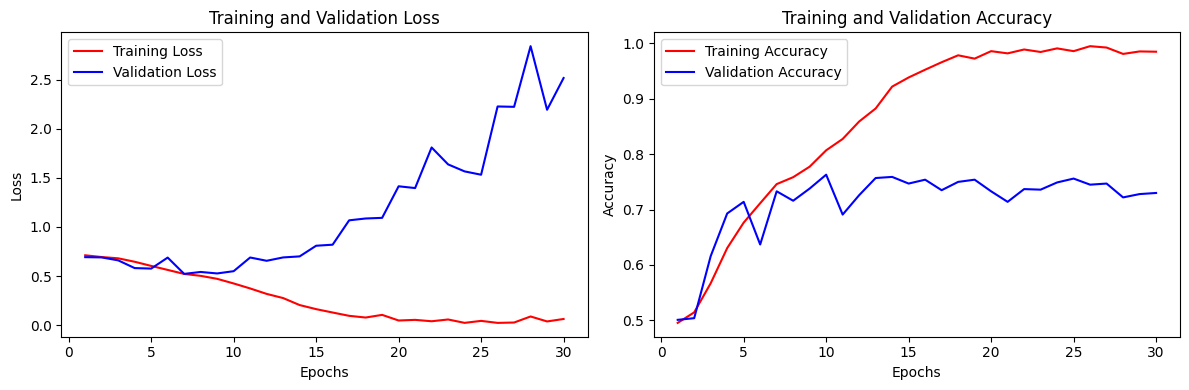

In [ ]:
import matplotlib.pyplot as plt

# Extract values from the training history
history_dict = history.history
training_loss = history_dict['loss']
validation_loss = history_dict['val_loss']
training_accuracy = history_dict['accuracy']
validation_accuracy = history_dict['val_accuracy']

# Setup the subplots for loss and accuracy
plt.figure(figsize=(12, 4))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(training_loss) + 1), training_loss, 'r-', label='Training Loss')
plt.plot(range(1, len(validation_loss) + 1), validation_loss, 'b-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(training_accuracy) + 1), training_accuracy, 'r-', label='Training Accuracy')
plt.plot(range(1, len(validation_accuracy) + 1), validation_accuracy, 'b-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


In these plots, you should see that the model is overfitting. Our training accuracy increases linearly over time, until it reaches nearly 100%, while our validation accuracy stalls at 70-72%. Our validation loss reaches its minimum after only five epochs then stalls, while the training loss keeps decreasing linearly until it reaches nearly 0.

Because we only have relatively few training samples (2000), overfitting is going to be our number one concern. There are many techniques that can help mitigate overfitting, such as reducing the number of epochs, adding dropout layers dropout, or weight decay (L2 regularization). We will look at them next weeks.

# **ConvNet 2 - Data Augmentation, Dropout**

## Part 1 Data Augmentation
Data augmentation takes the approach of generating more training data from existing training samples, by “augmenting” the samples via a number of random transformations that yield believable-looking images. The common-sense approach would be the manual creation of more images and applying small changes. However, it can be done easier and more efficiently in Keras, using ImageDataGenerator.

The goal is that at training time, our model would never see the exact same picture twice. It will change each image at the loading stage. This helps the model get exposed to more aspects of the data and generalize better. Below you can see an example. Where before we use only the rescale parameter, there are now several other random transformations:

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

These are just a few of the options available (for more, see the Keras documentation). Let's quickly go over what we just wrote:

* `rotation_range` is a value in degrees (0-180), a range within which to randomly rotate pictures.
* `width_shift` and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally.
* `shear_range` is for randomly applying shearing transformations.
* `zoom_range` is for randomly zooming inside pictures.
* `horizontal_flip` is for randomly flipping half of the images horizontally – relevant when there are no assumptions of horizontal asymmetry (e.g. real-world pictures).
* `fill_mode` is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.


If you load images using `image_dataset_from_directory` you can't do the augmentation while loading. Instead, you have to do Random layers as the first layers of your model. See documentation below.

[RandomRotation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomRotation) [RandomWidth](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomWidth)


In the next steps of the instruction you wont be able to easily visualise augmented data like in the code below. It would require seting parameter `data_augmentation.training = True`, then calling `data_augmentation.predict(…)` on a single image/batch.

Let's take a look at our augmented images:

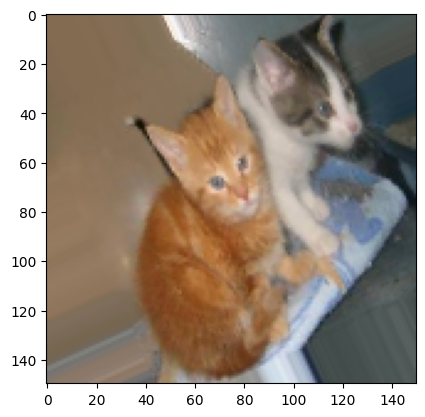

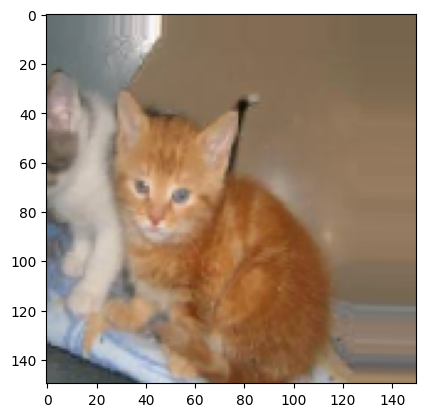

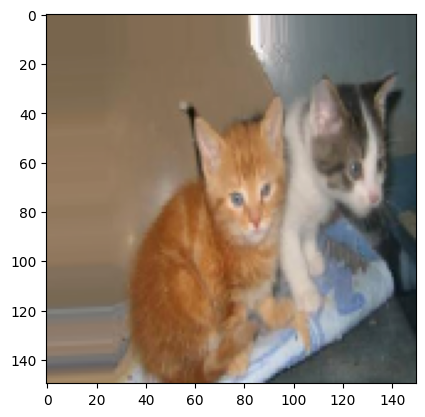

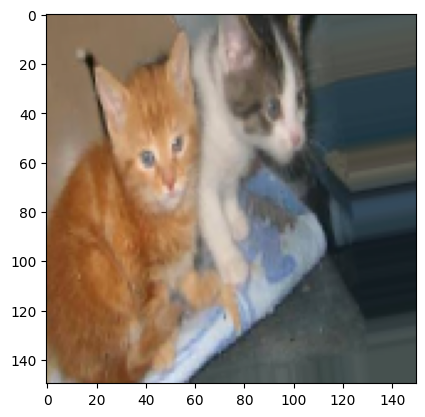

In [ ]:
# This is module with image preprocessing utilities
from keras.preprocessing import image
from matplotlib import pyplot as plt

fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

# We pick one image to "augment"
img_path = fnames[3]

# Read the image and resize it
img = image.load_img(img_path, target_size=(150, 150))

# Convert it to a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)

# Reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

If we train a new network using this data augmentation configuration, our network will never see twice the same input. However, the inputs that it sees are still heavily intercorrelated, since they come from a small number of original images, so the results won't be that much better.

Train the network using data augmentation:

In [ ]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=60,
      width_shift_range=0.4,
      height_shift_range=0.1,
      shear_range=0.3,
      zoom_range=0.3,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # Set target directory:
        train_dir,
        # Resize images to 150x150 pixels:
        target_size=(150, 150),
        # Experiment with different batches:
        batch_size=20,
        # Labels needed for binary_crossentropy loss:
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
model2 = models.Sequential()
model2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Flatten())
model2.add(layers.Dense(512, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))

model2.compile(optimizer='rmsprop',
                loss='binary_crossentropy',
                metrics=['accuracy'])


In [ ]:
history2 = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/100


<ipython-input-16-d7a6a056796b>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history2 = model.fit_generator(


100/100 [==============================] - 19s 190ms/step - loss: 0.8520 - accuracy: 0.6230 - val_loss: 0.7656 - val_accuracy: 0.5810
Epoch 2/100
100/100 [==============================] - 17s 172ms/step - loss: 0.6505 - accuracy: 0.6350 - val_loss: 0.5528 - val_accuracy: 0.7080
Epoch 3/100
100/100 [==============================] - 19s 186ms/step - loss: 0.6326 - accuracy: 0.6480 - val_loss: 0.5451 - val_accuracy: 0.7350
Epoch 4/100
100/100 [==============================] - 17s 174ms/step - loss: 0.6399 - accuracy: 0.6500 - val_loss: 0.5498 - val_accuracy: 0.7330
Epoch 5/100
100/100 [==============================] - 17s 170ms/step - loss: 0.6105 - accuracy: 0.6690 - val_loss: 0.5665 - val_accuracy: 0.7230
Epoch 6/100
100/100 [==============================] - 17s 171ms/step - loss: 0.6178 - accuracy: 0.6655 - val_loss: 0.5626 - val_accuracy: 0.7150
Epoch 7/100
100/100 [==============================] - 17s 168ms/step - loss: 0.5986 - accuracy: 0.6845 - val_loss: 0.5545 - val_accurac

Note, that this time we train the network longer (for about 100 epochs) and it still increases. If training takes too much time on your machine, you can try lower numbers. After 100 epochs you can expect validation accuracy of about 80-82%, after 30 epochs about 77%. Plot the results of 30 epochs and compare them with those without augmentation.

In [ ]:
history2_dict = history2.history
history2_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

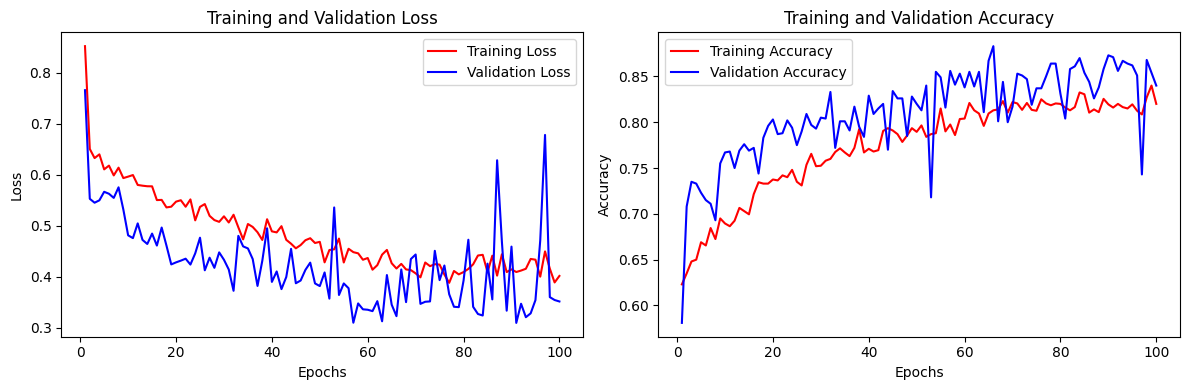

In [ ]:
import matplotlib.pyplot as plt

# Extract values from the training history2
history2_dict = history2.history
training_loss = history2_dict['loss']
validation_loss = history2_dict['val_loss']
training_accuracy = history2_dict['accuracy']
validation_accuracy = history2_dict['val_accuracy']

# Setup the subplots for loss and accuracy
plt.figure(figsize=(12, 4))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(training_loss) + 1), training_loss, 'r-', label='Training Loss')
plt.plot(range(1, len(validation_loss) + 1), validation_loss, 'b-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(training_accuracy) + 1), training_accuracy, 'r-', label='Training Accuracy')
plt.plot(range(1, len(validation_accuracy) + 1), validation_accuracy, 'b-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


## Part 2 Adding Dropout Layer

A dropout layer is a very simple, yet quite counter-intuitive method. What it does is basically cutting off half of the connection between the layers. You may ask yourself a question - Why do I train the network so hard, only to randomly throw half of the information away? Surprisingly, this works. In many situations network is overfitting to the data so much, that randomly cutting 20%, 30%, or even 50% of connection during training phase will be beneficial.

Therefore, to further combat overfitting, we will also add a Dropout layer to our Dogs and Cats example. Please configure the model with the same four convolutional layers and four max-pooling layers like last week, but this time add the Dropout layer right before the densely-connected classifier (with parameter 0.5).

### Network Architecture

In [ ]:
import os

base_dir = 'dogs-vs-cats/small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers

model3 = models.Sequential()
model3.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Conv2D(128, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Conv2D(128, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Flatten())
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(512, activation='relu'))
model3.add(layers.Dense(1, activation='sigmoid'))

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 17, 17, 128)      

### Data preprocessing

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


### Training and evaluation

Train the model again, using ImageDataGenerator.

In [ ]:
model3.compile(optimizer='rmsprop',
                loss='binary_crossentropy',
                metrics=['accuracy'])

In [ ]:
history3 = model3.fit(
      train_generator,
      steps_per_epoch= 100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps= 50)

Epoch 1/30
100/100 [==============================] - 7s 51ms/step - loss: 0.7905 - accuracy: 0.5105 - val_loss: 0.6923 - val_accuracy: 0.5550
Epoch 2/30
100/100 [==============================] - 7s 66ms/step - loss: 0.6943 - accuracy: 0.5375 - val_loss: 0.6876 - val_accuracy: 0.5050
Epoch 3/30
100/100 [==============================] - 5s 50ms/step - loss: 0.6761 - accuracy: 0.5765 - val_loss: 0.6368 - val_accuracy: 0.6260
Epoch 4/30
100/100 [==============================] - 6s 61ms/step - loss: 0.6356 - accuracy: 0.6380 - val_loss: 0.6153 - val_accuracy: 0.6370
Epoch 5/30
100/100 [==============================] - 6s 55ms/step - loss: 0.6148 - accuracy: 0.6515 - val_loss: 0.6014 - val_accuracy: 0.6630
Epoch 6/30
100/100 [==============================] - 5s 48ms/step - loss: 0.5879 - accuracy: 0.6870 - val_loss: 0.6137 - val_accuracy: 0.6620
Epoch 7/30
100/100 [==============================] - 7s 66ms/step - loss: 0.5495 - accuracy: 0.7185 - val_loss: 0.5989 - val_accuracy: 0.6550

Wy should expect higher accuracy, about 80-82% compared to 77-80% in the previous lab. Plot the results and compare them.

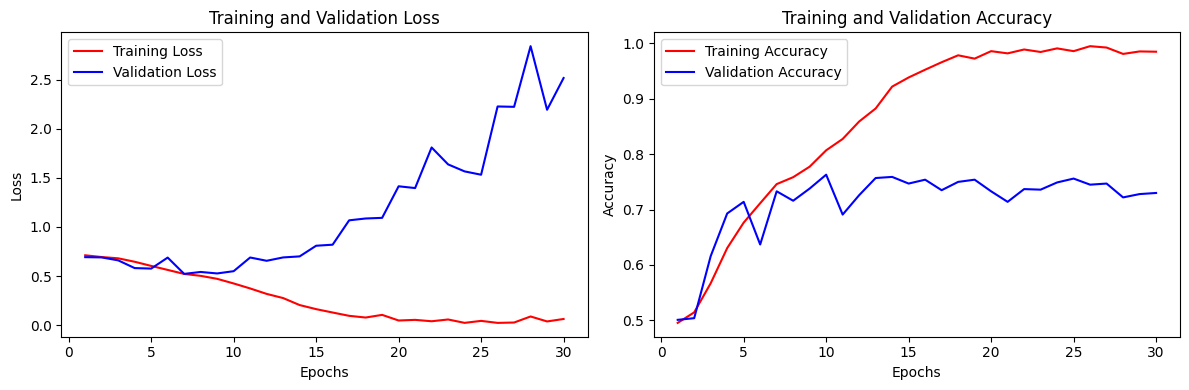

In [ ]:
#TODO: plot the results
import matplotlib.pyplot as plt

# Extract values from the training history2
history3_dict = history3.history
training_loss = history3_dict['loss']
validation_loss = history3_dict['val_loss']
training_accuracy = history3_dict['accuracy']
validation_accuracy = history3_dict['val_accuracy']

# Setup the subplots for loss and accuracy
plt.figure(figsize=(12, 4))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(training_loss) + 1), training_loss, 'r-', label='Training Loss')
plt.plot(range(1, len(validation_loss) + 1), validation_loss, 'b-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(training_accuracy) + 1), training_accuracy, 'r-', label='Training Accuracy')
plt.plot(range(1, len(validation_accuracy) + 1), validation_accuracy, 'b-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


# Otrzymano zysk skutecznosci na poziomie 6-7 punktow procentowych

If you want, you can also try training the model with a dropout layer, but without image augmentation, to see which one is better. Both methods should give better results than training without any of them, but worse than having them combined. You may, however, notice, that dropout is faster.

If you want, you can change the dropout parameter. Maybe we cut off too much? You can also try to experiment with putting the dropout layer in different places (maybe between convolutions), or even adding more dropout layers. There is hardly ever one universal way to implement a model. Make some modifications and comment on the results.

### Data augmentation + Dropout

In [ ]:
datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# This is module with image preprocessing utilities
from keras.preprocessing import image
from matplotlib import pyplot as plt

fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

# We pick one image to "augment"
img_path = fnames[3]

# Read the image and resize it
img = image.load_img(img_path, target_size=(150, 150))

# Convert it to a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)

# Reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
# for batch in datagen.flow(x, batch_size=1):
#     plt.figure(i)
#     imgplot = plt.imshow(image.array_to_img(batch[0]))
#     i += 1
#     if i % 4 == 0:
#         break

# plt.show()

In [ ]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=60,
      width_shift_range=0.4,
      height_shift_range=0.1,
      shear_range=0.3,
      zoom_range=0.3,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # Set target directory:
        train_dir,
        # Resize images to 150x150 pixels:
        target_size=(150, 150),
        # Experiment with different batches:
        batch_size=20,
        # Labels needed for binary_crossentropy loss:
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model4 = models.Sequential()
model4.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model4.add(layers.MaxPooling2D((2, 2)))
model4.add(layers.Conv2D(64, (3, 3), activation='relu'))
model4.add(layers.MaxPooling2D((2, 2)))
model4.add(layers.Conv2D(128, (3, 3), activation='relu'))
model4.add(layers.MaxPooling2D((2, 2)))
model4.add(layers.Conv2D(128, (3, 3), activation='relu'))
model4.add(layers.MaxPooling2D((2, 2)))
model4.add(layers.Flatten())
model4.add(layers.Dropout(0.5))
model4.add(layers.Dense(512, activation='relu'))
model4.add(layers.Dense(1, activation='sigmoid'))

model4.compile(optimizer='rmsprop',
                loss='binary_crossentropy',
                metrics=['accuracy'])


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
history4 = model4.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/100
100/100 [==============================] - 18s 168ms/step - loss: 0.7107 - accuracy: 0.4995 - val_loss: 0.6925 - val_accuracy: 0.6100
Epoch 2/100
100/100 [==============================] - 18s 177ms/step - loss: 0.6924 - accuracy: 0.5135 - val_loss: 0.6917 - val_accuracy: 0.5100
Epoch 3/100
100/100 [==============================] - 17s 167ms/step - loss: 0.6930 - accuracy: 0.5145 - val_loss: 0.6839 - val_accuracy: 0.5010
Epoch 4/100
100/100 [==============================] - 17s 166ms/step - loss: 0.6928 - accuracy: 0.5570 - val_loss: 0.6663 - val_accuracy: 0.5910
Epoch 5/100
100/100 [==============================] - 17s 168ms/step - loss: 0.6893 - accuracy: 0.5785 - val_loss: 0.6536 - val_accuracy: 0.6150
Epoch 6/100
100/100 [==============================] - 18s 176ms/step - loss: 0.6737 - accuracy: 0.5790 - val_loss: 0.6797 - val_accuracy: 0.5260
Epoch 7/100
100/100 [==============================] - 17s 168ms/step - loss: 0.6600 - accuracy: 0.6030 - val_loss: 0.6247 -

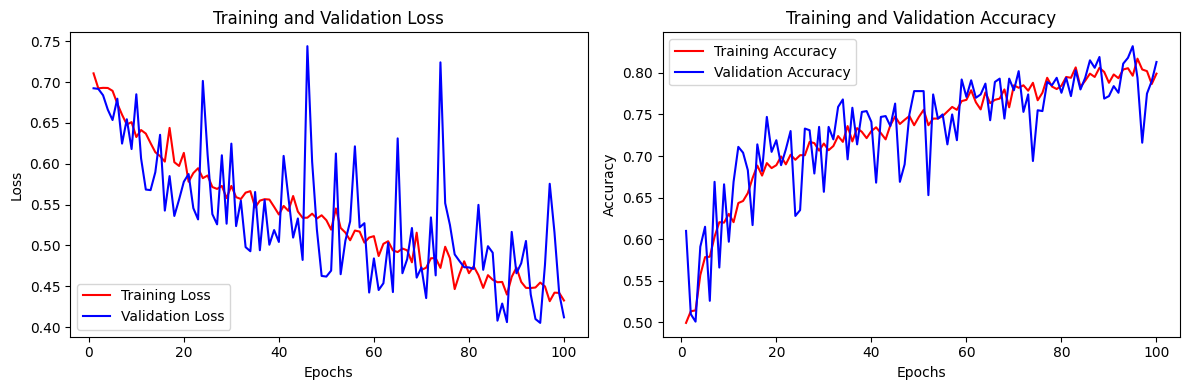

In [ ]:
#TODO: plot the results
import matplotlib.pyplot as plt

# Extract values from the training history2
history4_dict = history4.history
training_loss = history4_dict['loss']
validation_loss = history4_dict['val_loss']
training_accuracy = history4_dict['accuracy']
validation_accuracy = history4_dict['val_accuracy']

# Setup the subplots for loss and accuracy
plt.figure(figsize=(12, 4))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(training_loss) + 1), training_loss, 'r-', label='Training Loss')
plt.plot(range(1, len(validation_loss) + 1), validation_loss, 'b-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(training_accuracy) + 1), training_accuracy, 'r-', label='Training Accuracy')
plt.plot(range(1, len(validation_accuracy) + 1), validation_accuracy, 'b-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


# Otrzymano zysk skutecznosci na poziomie 6-7 punktow procentowych

### Hyperparameters

In [ ]:
import tensorflow as tf

class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.94):
            print("\nReached 94% accuracy so cancelling training!")
            self.model.stop_training = True

callback = MyCallback()

In [ ]:
from keras.datasets import imdb
import numpy as np
from sklearn.model_selection import train_test_split

def vectorize_sequences(sequences, dimension=10000):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)
# Vectorize labels
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.4, random_state=42)

network = models.Sequential()
network.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
network.add(layers.Dense(16, activation='relu'))
network.add(layers.Dense(1, activation='sigmoid'))

network.compile(optimizer='rmsprop',
                loss='binary_crossentropy',
                metrics=['accuracy'])

history3 = network.fit(x_train, y_train,
            batch_size=512,
            epochs=20,
            validation_data=(x_val, y_val),
            callbacks=[callback])

17464789/17464789 [==============================] - 0s 0us/step
Epoch 1/20
49/49 [==============================] - 4s 49ms/step - loss: 0.4527 - accuracy: 0.8188 - val_loss: 0.3613 - val_accuracy: 0.8566
Epoch 2/20
49/49 [==============================] - 1s 20ms/step - loss: 0.2660 - accuracy: 0.9049 - val_loss: 0.2870 - val_accuracy: 0.8858
Epoch 3/20
49/49 [==============================] - 1s 21ms/step - loss: 0.2101 - accuracy: 0.9233 - val_loss: 0.2999 - val_accuracy: 0.8744
Epoch 4/20
49/49 [==============================] - 1s 19ms/step - loss: 0.1794 - accuracy: 0.9346 - val_loss: 0.2928 - val_accuracy: 0.8807
Epoch 5/20
49/49 [==============================] - ETA: 0s - loss: 0.1576 - accuracy: 0.9440
Reached 94% accuracy so cancelling training!
49/49 [==============================] - 1s 21ms/step - loss: 0.1576 - accuracy: 0.9440 - val_loss: 0.2961 - val_accuracy: 0.8811


### Optimisation algorithms from sklearn

In [ ]:
!pip install scikeras
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from keras.utils import to_categorical
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
# from keras.wrappers.scikit_learn import KerasClassifier
from keras.datasets import reuters

def vectorize_sequences(sequences, dimension=10000):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results


def create_model():
    network = models.Sequential()
    network.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
    network.add(layers.Dense(64, activation='relu'))
    network.add(layers.Dense(46, activation='softmax'))

    network.compile(optimizer='rmsprop',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
    return network


(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

network2 = KerasClassifier(build_fn=create_model)

par1_batch = [64, 128, 256, 512]
par2_epochs = [3, 5, 10]

param_grid = dict(batch_size=par1_batch,
                  epochs=par2_epochs
                  )

grid = GridSearchCV(estimator=network2,
                    param_grid=param_grid,
                    cv = 3
                    )

print(x_train.shape)
print(y_train.shape)

grid_results = grid.fit(x_train, y_train)
print("Best: %f using %s" % (grid_results.best_score_, grid_results.best_params_))

2110848/2110848 [==============================] - 0s 0us/step
(7185, 10000)
(7185, 46)


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/3
75/75 [==============================] - 1s 4ms/step - loss: 1.8673 - accuracy: 0.6004
Epoch 2/3
75/75 [==============================] - 0s 4ms/step - loss: 1.0318 - accuracy: 0.7747
Epoch 3/3
38/38 [==============================] - 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/3
75/75 [==============================] - 1s 5ms/step - loss: 1.8640 - accuracy: 0.6148
Epoch 2/3
75/75 [==============================] - 0s 4ms/step - loss: 0.9830 - accuracy: 0.7804
Epoch 3/3
38/38 [==============================] - 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/3
75/75 [==============================] - 1s 6ms/step - loss: 1.9264 - accuracy: 0.6111
Epoch 2/3
75/75 [==============================] - 0s 6ms/step - loss: 1.0170 - accuracy: 0.7708
Epoch 3/3
38/38 [==============================] - 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
75/75 [==============================] - 1s 4ms/step - loss: 1.8696 - accuracy: 0.6050
Epoch 2/5
75/75 [==============================] - 0s 4ms/step - loss: 1.0067 - accuracy: 0.7787
Epoch 3/5
75/75 [==============================] - 0s 4ms/step - loss: 0.6650 - accuracy: 0.8587
Epoch 4/5
75/75 [==============================] - 0s 4ms/step - loss: 0.4388 - accuracy: 0.9088
Epoch 5/5
38/38 [==============================] - 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
75/75 [==============================] - 1s 5ms/step - loss: 1.8838 - accuracy: 0.6121
Epoch 2/5
75/75 [==============================] - 0s 4ms/step - loss: 0.9776 - accuracy: 0.7846
Epoch 3/5
75/75 [==============================] - 0s 4ms/step - loss: 0.6429 - accuracy: 0.8580
Epoch 4/5
75/75 [==============================] - 0s 4ms/step - loss: 0.4145 - accuracy: 0.9142
Epoch 5/5
38/38 [==============================] - 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
75/75 [==============================] - 1s 7ms/step - loss: 1.9138 - accuracy: 0.6102
Epoch 2/5
75/75 [==============================] - 0s 5ms/step - loss: 1.0173 - accuracy: 0.7752
Epoch 3/5
75/75 [==============================] - 0s 6ms/step - loss: 0.6826 - accuracy: 0.8516
Epoch 4/5
75/75 [==============================] - 0s 6ms/step - loss: 0.4530 - accuracy: 0.9104
Epoch 5/5
38/38 [==============================] - 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
75/75 [==============================] - 1s 4ms/step - loss: 1.8541 - accuracy: 0.5948
Epoch 2/10
75/75 [==============================] - 0s 4ms/step - loss: 1.0190 - accuracy: 0.7800
Epoch 3/10
75/75 [==============================] - 0s 4ms/step - loss: 0.6734 - accuracy: 0.8591
Epoch 4/10
75/75 [==============================] - 0s 4ms/step - loss: 0.4460 - accuracy: 0.9132
Epoch 5/10
75/75 [==============================] - 0s 4ms/step - loss: 0.3013 - accuracy: 0.9428
Epoch 6/10
75/75 [==============================] - 0s 4ms/step - loss: 0.2161 - accuracy: 0.9564
Epoch 7/10
75/75 [==============================] - 0s 4ms/step - loss: 0.1761 - accuracy: 0.9622
Epoch 8/10
75/75 [==============================] - 0s 4ms/step - loss: 0.1388 - accuracy: 0.9689
Epoch 9/10
75/75 [==============================] - 0s 4ms/step - loss: 0.1261 - accuracy: 0.9695
Epoch 10/10
38/38 [==============================] - 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
75/75 [==============================] - 1s 6ms/step - loss: 1.9393 - accuracy: 0.6002
Epoch 2/10
75/75 [==============================] - 0s 5ms/step - loss: 1.0245 - accuracy: 0.7653
Epoch 3/10
75/75 [==============================] - 0s 6ms/step - loss: 0.6754 - accuracy: 0.8555
Epoch 4/10
75/75 [==============================] - 0s 6ms/step - loss: 0.4380 - accuracy: 0.9146
Epoch 5/10
75/75 [==============================] - 0s 5ms/step - loss: 0.2983 - accuracy: 0.9403
Epoch 6/10
75/75 [==============================] - 0s 5ms/step - loss: 0.2136 - accuracy: 0.9562
Epoch 7/10
75/75 [==============================] - 0s 4ms/step - loss: 0.1738 - accuracy: 0.9618
Epoch 8/10
75/75 [==============================] - 0s 4ms/step - loss: 0.1382 - accuracy: 0.9674
Epoch 9/10
75/75 [==============================] - 0s 5ms/step - loss: 0.1230 - accuracy: 0.9678
Epoch 10/10
38/38 [==============================] - 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
75/75 [==============================] - 1s 4ms/step - loss: 1.9013 - accuracy: 0.6132
Epoch 2/10
75/75 [==============================] - 0s 4ms/step - loss: 0.9895 - accuracy: 0.7852
Epoch 3/10
75/75 [==============================] - 0s 4ms/step - loss: 0.6529 - accuracy: 0.8564
Epoch 4/10
75/75 [==============================] - 0s 4ms/step - loss: 0.4332 - accuracy: 0.9102
Epoch 5/10
75/75 [==============================] - 0s 4ms/step - loss: 0.3020 - accuracy: 0.9438
Epoch 6/10
75/75 [==============================] - 0s 4ms/step - loss: 0.2261 - accuracy: 0.9534
Epoch 7/10
75/75 [==============================] - 0s 5ms/step - loss: 0.1768 - accuracy: 0.9610
Epoch 8/10
75/75 [==============================] - 0s 4ms/step - loss: 0.1530 - accuracy: 0.9645
Epoch 9/10
75/75 [==============================] - 0s 4ms/step - loss: 0.1292 - accuracy: 0.9670
Epoch 10/10
38/38 [==============================] - 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/3
38/38 [==============================] - 1s 8ms/step - loss: 2.1748 - accuracy: 0.5676
Epoch 2/3
38/38 [==============================] - 0s 7ms/step - loss: 1.2193 - accuracy: 0.7299
Epoch 3/3
19/19 [==============================] - 0s 5ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/3
38/38 [==============================] - 1s 6ms/step - loss: 2.2230 - accuracy: 0.5443
Epoch 2/3
38/38 [==============================] - 0s 6ms/step - loss: 1.2141 - accuracy: 0.7190
Epoch 3/3
19/19 [==============================] - 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/3
38/38 [==============================] - 1s 6ms/step - loss: 2.1592 - accuracy: 0.5823
Epoch 2/3
38/38 [==============================] - 0s 6ms/step - loss: 1.1590 - accuracy: 0.7407
Epoch 3/3
19/19 [==============================] - 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
38/38 [==============================] - 1s 6ms/step - loss: 2.2088 - accuracy: 0.5722
Epoch 2/5
38/38 [==============================] - 0s 5ms/step - loss: 1.1620 - accuracy: 0.7459
Epoch 3/5
38/38 [==============================] - 0s 6ms/step - loss: 0.8233 - accuracy: 0.8259
Epoch 4/5
38/38 [==============================] - 0s 5ms/step - loss: 0.5953 - accuracy: 0.8754
Epoch 5/5
19/19 [==============================] - 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
38/38 [==============================] - 1s 6ms/step - loss: 2.2889 - accuracy: 0.5520
Epoch 2/5
38/38 [==============================] - 0s 8ms/step - loss: 1.2063 - accuracy: 0.7372
Epoch 3/5
38/38 [==============================] - 0s 8ms/step - loss: 0.8398 - accuracy: 0.8129
Epoch 4/5
38/38 [==============================] - 0s 7ms/step - loss: 0.5986 - accuracy: 0.8770
Epoch 5/5
19/19 [==============================] - 0s 5ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
38/38 [==============================] - 1s 8ms/step - loss: 2.2571 - accuracy: 0.5612
Epoch 2/5
38/38 [==============================] - 0s 6ms/step - loss: 1.2331 - accuracy: 0.7278
Epoch 3/5
38/38 [==============================] - 0s 5ms/step - loss: 0.8978 - accuracy: 0.8023
Epoch 4/5
38/38 [==============================] - 0s 6ms/step - loss: 0.6592 - accuracy: 0.8539
Epoch 5/5
19/19 [==============================] - 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
38/38 [==============================] - 1s 6ms/step - loss: 2.1461 - accuracy: 0.5720
Epoch 2/10
38/38 [==============================] - 0s 6ms/step - loss: 1.1724 - accuracy: 0.7441
Epoch 3/10
38/38 [==============================] - 0s 5ms/step - loss: 0.8430 - accuracy: 0.8188
Epoch 4/10
38/38 [==============================] - 0s 5ms/step - loss: 0.6156 - accuracy: 0.8695
Epoch 5/10
38/38 [==============================] - 0s 5ms/step - loss: 0.4485 - accuracy: 0.9067
Epoch 6/10
38/38 [==============================] - 0s 6ms/step - loss: 0.3320 - accuracy: 0.9359
Epoch 7/10
38/38 [==============================] - 0s 5ms/step - loss: 0.2524 - accuracy: 0.9503
Epoch 8/10
38/38 [==============================] - 0s 5ms/step - loss: 0.1987 - accuracy: 0.9591
Epoch 9/10
38/38 [==============================] - 0s 5ms/step - loss: 0.1634 - accuracy: 0.9658
Epoch 10/10
19/19 [==============================] - 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
38/38 [==============================] - 1s 6ms/step - loss: 2.2168 - accuracy: 0.5660
Epoch 2/10
38/38 [==============================] - 0s 5ms/step - loss: 1.1870 - accuracy: 0.7349
Epoch 3/10
38/38 [==============================] - 0s 5ms/step - loss: 0.8563 - accuracy: 0.8084
Epoch 4/10
38/38 [==============================] - 0s 5ms/step - loss: 0.6162 - accuracy: 0.8668
Epoch 5/10
38/38 [==============================] - 0s 6ms/step - loss: 0.4375 - accuracy: 0.9138
Epoch 6/10
38/38 [==============================] - 0s 6ms/step - loss: 0.3179 - accuracy: 0.9422
Epoch 7/10
38/38 [==============================] - 0s 5ms/step - loss: 0.2397 - accuracy: 0.9545
Epoch 8/10
38/38 [==============================] - 0s 6ms/step - loss: 0.1893 - accuracy: 0.9605
Epoch 9/10
38/38 [==============================] - 0s 7ms/step - loss: 0.1544 - accuracy: 0.9656
Epoch 10/10
19/19 [==============================] - 0s 5ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
38/38 [==============================] - 1s 7ms/step - loss: 2.1389 - accuracy: 0.5737
Epoch 2/10
38/38 [==============================] - 0s 7ms/step - loss: 1.1710 - accuracy: 0.7403
Epoch 3/10
38/38 [==============================] - 0s 7ms/step - loss: 0.8457 - accuracy: 0.8132
Epoch 4/10
38/38 [==============================] - 0s 7ms/step - loss: 0.6176 - accuracy: 0.8649
Epoch 5/10
38/38 [==============================] - 0s 6ms/step - loss: 0.4556 - accuracy: 0.9065
Epoch 6/10
38/38 [==============================] - 0s 6ms/step - loss: 0.3348 - accuracy: 0.9357
Epoch 7/10
38/38 [==============================] - 0s 5ms/step - loss: 0.2566 - accuracy: 0.9495
Epoch 8/10
38/38 [==============================] - 0s 6ms/step - loss: 0.2012 - accuracy: 0.9587
Epoch 9/10
38/38 [==============================] - 0s 5ms/step - loss: 0.1637 - accuracy: 0.9656
Epoch 10/10
19/19 [==============================] - 0s 7ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/3
19/19 [==============================] - 1s 8ms/step - loss: 2.4829 - accuracy: 0.5152
Epoch 2/3
19/19 [==============================] - 0s 8ms/step - loss: 1.4636 - accuracy: 0.6716
Epoch 3/3
10/10 [==============================] - 0s 7ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/3
19/19 [==============================] - 1s 9ms/step - loss: 2.6054 - accuracy: 0.4908
Epoch 2/3
19/19 [==============================] - 0s 8ms/step - loss: 1.4457 - accuracy: 0.6925
Epoch 3/3
10/10 [==============================] - 0s 6ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/3
19/19 [==============================] - 1s 9ms/step - loss: 2.6147 - accuracy: 0.5040
Epoch 2/3
19/19 [==============================] - 0s 8ms/step - loss: 1.4288 - accuracy: 0.6927
Epoch 3/3
10/10 [==============================] - 0s 7ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
19/19 [==============================] - 1s 13ms/step - loss: 2.6868 - accuracy: 0.4879
Epoch 2/5
19/19 [==============================] - 0s 11ms/step - loss: 1.5145 - accuracy: 0.6797
Epoch 3/5
19/19 [==============================] - 0s 11ms/step - loss: 1.1450 - accuracy: 0.7589
Epoch 4/5
19/19 [==============================] - 0s 10ms/step - loss: 0.8975 - accuracy: 0.8152
Epoch 5/5
10/10 [==============================] - 0s 7ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
19/19 [==============================] - 1s 8ms/step - loss: 2.5113 - accuracy: 0.5217
Epoch 2/5
19/19 [==============================] - 0s 8ms/step - loss: 1.4165 - accuracy: 0.6875
Epoch 3/5
19/19 [==============================] - 0s 8ms/step - loss: 1.0623 - accuracy: 0.7666
Epoch 4/5
19/19 [==============================] - 0s 8ms/step - loss: 0.8298 - accuracy: 0.8142
Epoch 5/5
10/10 [==============================] - 0s 6ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
19/19 [==============================] - 1s 8ms/step - loss: 2.5500 - accuracy: 0.5307
Epoch 2/5
19/19 [==============================] - 0s 9ms/step - loss: 1.4208 - accuracy: 0.6956
Epoch 3/5
19/19 [==============================] - 0s 9ms/step - loss: 1.0668 - accuracy: 0.7710
Epoch 4/5
19/19 [==============================] - 0s 9ms/step - loss: 0.8412 - accuracy: 0.8221
Epoch 5/5
10/10 [==============================] - 0s 7ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
19/19 [==============================] - 1s 9ms/step - loss: 2.6236 - accuracy: 0.4992
Epoch 2/10
19/19 [==============================] - 0s 8ms/step - loss: 1.4910 - accuracy: 0.6706
Epoch 3/10
19/19 [==============================] - 0s 9ms/step - loss: 1.1173 - accuracy: 0.7574
Epoch 4/10
19/19 [==============================] - 0s 8ms/step - loss: 0.8741 - accuracy: 0.8198
Epoch 5/10
19/19 [==============================] - 0s 9ms/step - loss: 0.6881 - accuracy: 0.8557
Epoch 6/10
19/19 [==============================] - 0s 9ms/step - loss: 0.5473 - accuracy: 0.8898
Epoch 7/10
19/19 [==============================] - 0s 8ms/step - loss: 0.4376 - accuracy: 0.9129
Epoch 8/10
19/19 [==============================] - 0s 8ms/step - loss: 0.3464 - accuracy: 0.9334
Epoch 9/10
19/19 [==============================] - 0s 9ms/step - loss: 0.2813 - accuracy: 0.9434
Epoch 10/10
10/10 [==============================] - 0s 8ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
19/19 [==============================] - 1s 11ms/step - loss: 2.6027 - accuracy: 0.4942
Epoch 2/10
19/19 [==============================] - 0s 11ms/step - loss: 1.4395 - accuracy: 0.6902
Epoch 3/10
19/19 [==============================] - 0s 11ms/step - loss: 1.0694 - accuracy: 0.7601
Epoch 4/10
19/19 [==============================] - 0s 13ms/step - loss: 0.8342 - accuracy: 0.8180
Epoch 5/10
19/19 [==============================] - 0s 12ms/step - loss: 0.6567 - accuracy: 0.8641
Epoch 6/10
19/19 [==============================] - 0s 10ms/step - loss: 0.5151 - accuracy: 0.8998
Epoch 7/10
19/19 [==============================] - 0s 9ms/step - loss: 0.4070 - accuracy: 0.9232
Epoch 8/10
19/19 [==============================] - 0s 8ms/step - loss: 0.3238 - accuracy: 0.9403
Epoch 9/10
19/19 [==============================] - 0s 9ms/step - loss: 0.2611 - accuracy: 0.9511
Epoch 10/10
10/10 [==============================] - 0s 8ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
19/19 [==============================] - 1s 9ms/step - loss: 2.5857 - accuracy: 0.5027
Epoch 2/10
19/19 [==============================] - 0s 9ms/step - loss: 1.4407 - accuracy: 0.6866
Epoch 3/10
19/19 [==============================] - 0s 8ms/step - loss: 1.0849 - accuracy: 0.7608
Epoch 4/10
19/19 [==============================] - 0s 9ms/step - loss: 0.8454 - accuracy: 0.8192
Epoch 5/10
19/19 [==============================] - 0s 9ms/step - loss: 0.6622 - accuracy: 0.8587
Epoch 6/10
19/19 [==============================] - 0s 8ms/step - loss: 0.5206 - accuracy: 0.8923
Epoch 7/10
19/19 [==============================] - 0s 8ms/step - loss: 0.4164 - accuracy: 0.9182
Epoch 8/10
19/19 [==============================] - 0s 8ms/step - loss: 0.3318 - accuracy: 0.9355
Epoch 9/10
19/19 [==============================] - 0s 8ms/step - loss: 0.2720 - accuracy: 0.9459
Epoch 10/10
10/10 [==============================] - 0s 7ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/3
10/10 [==============================] - 1s 14ms/step - loss: 3.2290 - accuracy: 0.4198
Epoch 2/3
10/10 [==============================] - 0s 15ms/step - loss: 2.0085 - accuracy: 0.6013
Epoch 3/3
5/5 [==============================] - 0s 9ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/3
10/10 [==============================] - 1s 15ms/step - loss: 3.1968 - accuracy: 0.4605
Epoch 2/3
10/10 [==============================] - 0s 14ms/step - loss: 1.9675 - accuracy: 0.6347
Epoch 3/3
5/5 [==============================] - 0s 9ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/3
10/10 [==============================] - 1s 20ms/step - loss: 2.9345 - accuracy: 0.4518
Epoch 2/3
10/10 [==============================] - 0s 17ms/step - loss: 1.7777 - accuracy: 0.6378
Epoch 3/3
5/5 [==============================] - 0s 16ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
10/10 [==============================] - 1s 15ms/step - loss: 3.1753 - accuracy: 0.4324
Epoch 2/5
10/10 [==============================] - 0s 15ms/step - loss: 1.8827 - accuracy: 0.6184
Epoch 3/5
10/10 [==============================] - 0s 14ms/step - loss: 1.4336 - accuracy: 0.7038
Epoch 4/5
10/10 [==============================] - 0s 16ms/step - loss: 1.1976 - accuracy: 0.7463
Epoch 5/5
5/5 [==============================] - 0s 9ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
10/10 [==============================] - 1s 15ms/step - loss: 3.1461 - accuracy: 0.4451
Epoch 2/5
10/10 [==============================] - 0s 14ms/step - loss: 1.9488 - accuracy: 0.5889
Epoch 3/5
10/10 [==============================] - 0s 15ms/step - loss: 1.4453 - accuracy: 0.6831
Epoch 4/5
10/10 [==============================] - 0s 15ms/step - loss: 1.1709 - accuracy: 0.7367
Epoch 5/5
5/5 [==============================] - 0s 10ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
10/10 [==============================] - 1s 15ms/step - loss: 3.1730 - accuracy: 0.4639
Epoch 2/5
10/10 [==============================] - 0s 14ms/step - loss: 1.9976 - accuracy: 0.6109
Epoch 3/5
10/10 [==============================] - 0s 15ms/step - loss: 1.4856 - accuracy: 0.6912
Epoch 4/5
10/10 [==============================] - 0s 14ms/step - loss: 1.2164 - accuracy: 0.7378
Epoch 5/5
5/5 [==============================] - 0s 9ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
10/10 [==============================] - 1s 15ms/step - loss: 3.2447 - accuracy: 0.4426
Epoch 2/10
10/10 [==============================] - 0s 17ms/step - loss: 1.9694 - accuracy: 0.6125
Epoch 3/10
10/10 [==============================] - 0s 15ms/step - loss: 1.4762 - accuracy: 0.6877
Epoch 4/10
10/10 [==============================] - 0s 16ms/step - loss: 1.2126 - accuracy: 0.7392
Epoch 5/10
10/10 [==============================] - 0s 20ms/step - loss: 1.0285 - accuracy: 0.7802
Epoch 6/10
10/10 [==============================] - 0s 20ms/step - loss: 0.8897 - accuracy: 0.8129
Epoch 7/10
10/10 [==============================] - 0s 18ms/step - loss: 0.7684 - accuracy: 0.8413
Epoch 8/10
10/10 [==============================] - 0s 18ms/step - loss: 0.6651 - accuracy: 0.8614
Epoch 9/10
10/10 [==============================] - 0s 20ms/step - loss: 0.5771 - accuracy: 0.8795
Epoch 10/10
5/5 [==============================] - 0s 17ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
10/10 [==============================] - 1s 15ms/step - loss: 2.9732 - accuracy: 0.3760
Epoch 2/10
10/10 [==============================] - 0s 15ms/step - loss: 1.8451 - accuracy: 0.6029
Epoch 3/10
10/10 [==============================] - 0s 12ms/step - loss: 1.4057 - accuracy: 0.6952
Epoch 4/10
10/10 [==============================] - 0s 15ms/step - loss: 1.1591 - accuracy: 0.7478
Epoch 5/10
10/10 [==============================] - 0s 15ms/step - loss: 0.9857 - accuracy: 0.7864
Epoch 6/10
10/10 [==============================] - 0s 15ms/step - loss: 0.8450 - accuracy: 0.8165
Epoch 7/10
10/10 [==============================] - 0s 16ms/step - loss: 0.7342 - accuracy: 0.8390
Epoch 8/10
10/10 [==============================] - 0s 14ms/step - loss: 0.6269 - accuracy: 0.8653
Epoch 9/10
10/10 [==============================] - 0s 15ms/step - loss: 0.5380 - accuracy: 0.8900
Epoch 10/10
5/5 [==============================] - 0s 10ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
10/10 [==============================] - 1s 16ms/step - loss: 3.0178 - accuracy: 0.4597
Epoch 2/10
10/10 [==============================] - 0s 14ms/step - loss: 1.8390 - accuracy: 0.6253
Epoch 3/10
10/10 [==============================] - 0s 16ms/step - loss: 1.4348 - accuracy: 0.6802
Epoch 4/10
10/10 [==============================] - 0s 15ms/step - loss: 1.1875 - accuracy: 0.7365
Epoch 5/10
10/10 [==============================] - 0s 14ms/step - loss: 1.0042 - accuracy: 0.7804
Epoch 6/10
10/10 [==============================] - 0s 14ms/step - loss: 0.8573 - accuracy: 0.8140
Epoch 7/10
10/10 [==============================] - 0s 14ms/step - loss: 0.7345 - accuracy: 0.8382
Epoch 8/10
10/10 [==============================] - 0s 14ms/step - loss: 0.6336 - accuracy: 0.8614
Epoch 9/10
10/10 [==============================] - 0s 15ms/step - loss: 0.5380 - accuracy: 0.8860
Epoch 10/10
5/5 [==============================] - 0s 10ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
113/113 [==============================] - 1s 5ms/step - loss: 1.6458 - accuracy: 0.6426
Epoch 2/10
113/113 [==============================] - 1s 5ms/step - loss: 0.8915 - accuracy: 0.7964
Epoch 3/10
113/113 [==============================] - 1s 4ms/step - loss: 0.5738 - accuracy: 0.8770
Epoch 4/10
113/113 [==============================] - 1s 6ms/step - loss: 0.3845 - accuracy: 0.9170
Epoch 5/10
113/113 [==============================] - 1s 6ms/step - loss: 0.2783 - accuracy: 0.9389
Epoch 6/10
113/113 [==============================] - 1s 6ms/step - loss: 0.2187 - accuracy: 0.9513
Epoch 7/10
113/113 [==============================] - 1s 6ms/step - loss: 0.1827 - accuracy: 0.9543
Epoch 8/10
113/113 [==============================] - 1s 6ms/step - loss: 0.1675 - accuracy: 0.9559
Epoch 9/10
113/113 [==============================] - 1s 6ms/step - loss: 0.1518 - accuracy: 0.9566
Epoch 10/10
113/113 [==============================] - 1s 5ms/step - loss: 0.1413 - accuracy: 0.9595